# Bee Sound Classification - Data Preprocessing

## Globals

In [ ]:
%pip install librosa
%pip install tensorflow

In [ ]:
import os
import pickle
from tqdm import tqdm

from pydub import AudioSegment
from pydub.utils import make_chunks
import librosa
import librosa.display

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [ ]:
RAW_RECORDINGS = 'Data Bee\\Raw Recordings'
MARKED_RECORDINGS = 'Data Bee\\Marked Recordings'
SPLITTED_RECORDINGS = 'Data Bee\\Splitted Recordings 2.96 0.75'

SWARMING = 'Swarming'
NO_QUEEN_BEE = 'NoQueenBee'
QUEEN_BEE = 'QueenBee'
NO_BEE = 'NoBee'

SAMPLE_RATE = 22050

In [ ]:
def dir_eixst(dirs):
    for path in dirs:
        if not os.path.exists(path):
            os.makedirs(path)


## Bee Preprocess

### Raw Recordings Processing

In [ ]:
dir_eixst([RAW_RECORDINGS, MARKED_RECORDINGS])

In [ ]:
#Create pairs of (.lab, .wav) grouped by label
total = lab = wav = 0
to_process = {'QueenBee': [], 'NoQueenBee': [], 'Swarming': []}

for dirname, _, filenames in os.walk(RAW_RECORDINGS):
    for filename in filenames:
        total += 1
        if filename.endswith('.lab'):
            lab += 1
            lab_str = os.path.join(RAW_RECORDINGS, filename)
        else:
            wav += 1
            wav_str = os.path.join(RAW_RECORDINGS, filename)
        if lab == wav:
            if 'Swarming' in filename:
                to_process[SWARMING].append((lab_str, wav_str))
            elif 'Missing Queen' in filename or 'NO_QueenBee' in filename:
                to_process[NO_QUEEN_BEE].append((lab_str, wav_str))
            elif 'Active' in filename or 'QueenBee' in filename:
                to_process[QUEEN_BEE].append((lab_str, wav_str))

In [ ]:
#Split audio according to .lab
for label, data in to_process.items():
    for lab_name, audio_name_path in data:
        with open(lab_name) as f:
            content = f.read().splitlines()[1:-1]
        content = map(lambda it: it.split('\t'), content)

        audio_format = audio_name_path.rsplit('.')[-1]
        sample = AudioSegment.from_wav(audio_name_path)
        audio_name = audio_name_path.rsplit('\\',)[-1]

        line = 0
        for s, e, marker in content:
            line += 1
            s = int((float(s)) * 1000)
            e = int(round((float(e)+0.01), 2) * 1000)

            new_sample = sample[s:e]

            if len(new_sample.get_array_of_samples()):
                new_path = os.path.join(
                    MARKED_RECORDINGS, f'{label} {marker} {line} {audio_name}')
                new_sample.export(new_path, format=audio_format).close()

### Audio Splitting

In [ ]:
class AudioProcessPipeline:

    def __init__(self):
        self.processor = None

    def process(self, audio_files_dir):
        for root, _, files in os.walk(audio_files_dir):
            for file in files:
                file_path = os.path.join(root, file)
                self.processor.process(file_path)

In [ ]:
class AudioSplitter():
    """AudioSplitter is responsible for splitting an audio file in chuncks"""

    def __init__(self, sec_per_split, gap, dir='\\'):
        self.__per_split = int(sec_per_split * 1000)
        self.__gap = gap
        self.__dir = dir

    def split(self, file_path):
        audio = AudioSegment.from_wav(file_path)
        chunks = make_chunks(audio, self.__per_split)
        for i, chunk in enumerate(chunks):
            path, audio_format = file_path.rsplit('.', 1)
            filename = path.split('\\')[-1]
            path = os.path.join(
                self.__dir, f'{filename} {i} - {chunk.duration_seconds} .{audio_format}')
            if chunk.duration_seconds >= (self.__per_split/1000)*self.__gap:
                chunk.export(path, format=audio_format)

In [ ]:
SEC_PER_SPLIT = 2.96
ALLOWED_GAP = 0.75
SPLITTED_RECORDINGS = f'Data Bee\\Splitted Recordings {SEC_PER_SPLIT} {ALLOWED_GAP}'
dir_eixst([SPLITTED_RECORDINGS])

In [ ]:
splitter = AudioSplitter(SEC_PER_SPLIT, ALLOWED_GAP, SPLITTED_RECORDINGS)
audio_split_pipeline = AudioSplitPipeline()
audio_split_pipeline.splitter = splitter
audio_split_pipeline.process(MARKED_RECORDINGS)

### Audio Processing (Not Necessary)

In [ ]:
class Loader:
    """Loader is responsible for loading an audio file."""

    def __init__(self, sample_rate, duration, mono):
        self.sample_rate = sample_rate
        self.duration = duration
        self.mono = mono

    def load(self, file_path):
        signal = librosa.load(file_path,
                              sr=self.sample_rate,
                              duration=self.duration,
                              mono=self.mono)[0]
        return signal

In [ ]:
class Padder:
    """Padder is responsible to apply padding to an array."""

    def __init__(self, mode="constant"):
        self.mode = mode

    def left_pad(self, array, num_missing_items):
        padded_array = np.pad(array,
                              (num_missing_items, 0),
                              mode=self.mode)
        return padded_array

    def right_pad(self, array, num_missing_items):
        padded_array = np.pad(array,
                              (0, num_missing_items),
                              mode=self.mode)
        return padded_array


In [ ]:
class LogSpectrogramExtractor:
    """LogSpectrogramExtractor extracts log spectrograms (in dB) from a
    time-series signal.
    """

    def __init__(self, frame_size, hop_length):
        self.frame_size = frame_size
        self.hop_length = hop_length

    def extract(self, signal):
        stft = librosa.stft(y=signal,
                            n_fft=self.frame_size,
                            hop_length=self.hop_length)[:-1]
        spectrogram = np.abs(stft)
        log_spectrogram = librosa.amplitude_to_db(spectrogram)
        return log_spectrogram


In [ ]:
class LogMelSpectrogramExtractor:
    """LogMelSpectrogramExtractor extracts log mel spectrograms (in dB) from a
    time-series signal.
    """

    def __init__(self, frame_size, hop_length):
        self.frame_size = frame_size
        self.hop_length = hop_length

    def extract(self, signal):
        mel = librosa.feature.melspectrogram(y=signal,
                                             n_fft=self.frame_size,
                                             hop_length=self.hop_length)[:-1]

        log_mel_spectrogram = librosa.amplitude_to_db(mel)
        return log_mel_spectrogram


In [ ]:
class MFCCSpectogramExtractor:
    """MFCCSpectogramExtractor extracts mfcc from a
    time-series signal.
    """

    def __init__(self, frame_size, hop_length):
        self.frame_size = frame_size
        self.hop_length = hop_length

    def extract(self, signal):
        mfcc = librosa.feature.mfcc(y=signal,
                                    n_fft=self.frame_size,
                                    hop_length=self.hop_length)[:-1]
        return mfcc


In [ ]:
class MinMaxNormaliser:
    """MinMaxNormaliser applies min max normalisation to an array."""

    def __init__(self, min_val, max_val):
        self.min = min_val
        self.max = max_val

    def normalise(self, array):
        norm_array = (array - array.min()) / (array.max() - array.min())
        norm_array = norm_array * (self.max - self.min) + self.min
        return norm_array

    def denormalise(self, norm_array, original_min, original_max):
        array = (norm_array - self.min) / (self.max - self.min)
        array = array * (original_max - original_min) + original_min
        return array


In [ ]:
class Saver:
    """Saver is responsible to save features, and the min max values."""

    def __init__(self, feature_save_dir, min_max_values_save_dir):
        self.feature_save_dir = feature_save_dir
        self.min_max_values_save_dir = min_max_values_save_dir

    def save_feature(self, feature, file_path):
        save_path = self._generate_save_path(file_path)
        np.save(save_path, feature)

    def save_min_max_values(self, min_max_values):
        save_path = os.path.join(self.min_max_values_save_dir,
                                 "min_max_values.pkl")
        self._save(min_max_values, save_path)

    @staticmethod
    def _save(data, save_path):
        with open(save_path, "wb") as f:
            pickle.dump(data, f)

    def _generate_save_path(self, file_path):
        file_name = os.path.split(file_path)[1]
        save_path = os.path.join(self.feature_save_dir, file_name + ".npy")
        return save_path


In [ ]:
class PreprocessingPipeline:
    """PreprocessingPipeline processes audio files in a directory, applying
    the following steps to each file:
        1- load a file
        2- pad the signal (if necessary)
        3- extracting log spectrogram from signal
        4- normalise spectrogram
        5- save the normalised spectrogram
    Storing the min max values for all the log spectrograms.
    """

    def __init__(self):
        self.padder = None
        self.extractor = None
        self.normaliser = None
        self.saver = None
        self.min_max_values = {}
        self._loader = None
        self._num_expected_samples = None

    @property
    def loader(self):
        return self._loader

    @loader.setter
    def loader(self, loader):
        self._loader = loader
        self._num_expected_samples = int(loader.sample_rate * loader.duration)

    def process(self, audio_files_dir):
        for root, _, files in os.walk(audio_files_dir):
            for file in files:
                file_path = os.path.join(root, file)
                self._process_file(file_path)
                print(f"Processed file {file_path}")
        self.saver.save_min_max_values(self.min_max_values)

    def _process_file(self, file_path):
        signal = self.loader.load(file_path)
        if self._is_padding_necessary(signal):
            signal = self._apply_padding(signal)
        feature = self.extractor.extract(signal)
        norm_feature = self.normaliser.normalise(feature)
        save_path = self.saver.save_feature(norm_feature, file_path)
        self._store_min_max_value(save_path, feature.min(), feature.max())

    def _is_padding_necessary(self, signal):
        if len(signal) < self._num_expected_samples:
            return True
        return False

    def _apply_padding(self, signal):
        num_missing_samples = self._num_expected_samples - len(signal)
        padded_signal = self.padder.right_pad(signal, num_missing_samples)
        return padded_signal

    def _store_min_max_value(self, save_path, min_val, max_val):
        self.min_max_values[save_path] = {
            "min": min_val,
            "max": max_val
        }


In [ ]:
FRAME_SIZE = 512
HOP_LENGTH = 256
DURATION = 2.96  # in seconds
SAMPLE_RATE = 22050
MONO = True

SPECTROGRAMS_SAVE_DIR = "Data Bee//Log Spectrograms/"
MIN_MAX_VALUES_SAVE_DIR = "Data Bee//Log Min Max/"

dir_eixst([SPECTROGRAMS_SAVE_DIR, MIN_MAX_VALUES_SAVE_DIR])

# instantiate all objects
loader = Loader(SAMPLE_RATE, DURATION, MONO)
padder = Padder()
log_spectrogram_extractor = LogSpectrogramExtractor(FRAME_SIZE, HOP_LENGTH)
min_max_normaliser = MinMaxNormaliser(0, 1)
saver = Saver(SPECTROGRAMS_SAVE_DIR, MIN_MAX_VALUES_SAVE_DIR)

preprocessing_pipeline = PreprocessingPipeline()
preprocessing_pipeline.loader = loader
preprocessing_pipeline.padder = padder
preprocessing_pipeline.extractor = log_spectrogram_extractor
preprocessing_pipeline.normaliser = min_max_normaliser
preprocessing_pipeline.saver = saver

preprocessing_pipeline.process(SPLITTED_RECORDINGS)


In [ ]:
FRAME_SIZE = 512
HOP_LENGTH = 256
DURATION = 2.96  # in seconds
SAMPLE_RATE = 22050
MONO = True

SPECTROGRAMS_SAVE_DIR = "Data Bee//Log Mel Spectrograms/"
MIN_MAX_VALUES_SAVE_DIR = "Data Bee//Log Mel Min Max/"

dir_eixst([SPECTROGRAMS_SAVE_DIR, MIN_MAX_VALUES_SAVE_DIR])

# instantiate all objects
loader = Loader(SAMPLE_RATE, DURATION, MONO)
padder = Padder()
log_mel_spectrogram_extractor = LogMelSpectrogramExtractor(FRAME_SIZE, HOP_LENGTH)
min_max_normaliser = MinMaxNormaliser(0, 1)
saver = Saver(SPECTROGRAMS_SAVE_DIR, MIN_MAX_VALUES_SAVE_DIR)

preprocessing_pipeline = PreprocessingPipeline()
preprocessing_pipeline.loader = loader
preprocessing_pipeline.padder = padder
preprocessing_pipeline.extractor = log_mel_spectrogram_extractor
preprocessing_pipeline.normaliser = min_max_normaliser
preprocessing_pipeline.saver = saver

preprocessing_pipeline.process(SPLITTED_RECORDINGS)


In [ ]:
FRAME_SIZE = 512
HOP_LENGTH = 256
DURATION = 2.96  # in seconds
SAMPLE_RATE = 22050
MONO = True

SPECTROGRAMS_SAVE_DIR = "Data Bee//MFCC Spectrograms/"
MIN_MAX_VALUES_SAVE_DIR = "Data Bee//MFCC Min Max/"

dir_eixst([SPECTROGRAMS_SAVE_DIR, MIN_MAX_VALUES_SAVE_DIR])

# instantiate all objects
loader = Loader(SAMPLE_RATE, DURATION, MONO)
padder = Padder()
mfcc_spectrogram_extractor = MFCCSpectogramExtractor(FRAME_SIZE, HOP_LENGTH)
min_max_normaliser = MinMaxNormaliser(0, 1)
saver = Saver(SPECTROGRAMS_SAVE_DIR, MIN_MAX_VALUES_SAVE_DIR)

preprocessing_pipeline = PreprocessingPipeline()
preprocessing_pipeline.loader = loader
preprocessing_pipeline.padder = padder
preprocessing_pipeline.extractor = mfcc_spectrogram_extractor
preprocessing_pipeline.normaliser = min_max_normaliser
preprocessing_pipeline.saver = saver

preprocessing_pipeline.process(SPLITTED_RECORDINGS)


### Audio Augmentetion

In [ ]:
def time_shift(audio_name_path, start_second, save_path):
    '''Shifts the start of audio file'''
    
    sample = AudioSegment.from_file(audio_name_path, start_second=start_second)
    if len(sample.get_array_of_samples()):
        audio_name = audio_name_path.rsplit('\\',)[-1]
        audio_format = audio_name_path.rsplit('.',)[-1]
        label, marker, rest = audio_name.split(' ', 2)
        new_path = os.path.join(
            save_path, f'{label} {marker} shifted {start_second} {rest}')
        sample.export(new_path, format=audio_format).close()


In [ ]:
#files to shift
audio_filenames = []
for dirname, _, filenames in os.walk(MARKED_RECORDINGS):
    for filename in filenames:
        if filename.startswith(SWARMING+' bee'):
            audio_filenames.append(os.path.join(dirname, filename))


In [ ]:
DURATION = 2.96  # in seconds
SHIFTED_MARKED_RECORDINGS = 'Data Bee\\Shifted Marked Recordings'
dir_eixst([SHIFTED_MARKED_RECORDINGS])

for filename in audio_filenames:
    for start_second in [DURATION/4, DURATION/3, DURATION/2]:
        time_shift(filename, start_second, SHIFTED_MARKED_RECORDINGS)


In [ ]:
SEC_PER_SPLIT = 2.96
ALLOWED_GAP = 0.75
SHIFTED_SPLITED_RECORDINGS = f'Data Bee\\Shifted Splitted Recordings {SEC_PER_SPLIT} {ALLOWED_GAP}'

dir_eixst([SHIFTED_SPLITED_RECORDINGS])

In [ ]:
splitter = AudioSplitter(SEC_PER_SPLIT, ALLOWED_GAP,
                         SHIFTED_SPLITED_RECORDINGS)
audio_split_pipeline = AudioSplitPipeline()
audio_split_pipeline.splitter = splitter
audio_split_pipeline.process(SHIFTED_MARKED_RECORDINGS)


### Augmented Data Processing (Not Necessary)

In [ ]:
FRAME_SIZE = 512
HOP_LENGTH = 256
DURATION = 2.96  # in seconds
SAMPLE_RATE = 22050
MONO = True

In [ ]:
SPECTROGRAMS_SAVE_DIR = "Data Bee//Shifted Log Spectrograms/"
MIN_MAX_VALUES_SAVE_DIR = "Data Bee//Shifted Log Min Max/"

dir_eixst([SPECTROGRAMS_SAVE_DIR, MIN_MAX_VALUES_SAVE_DIR])

# instantiate all objects
loader = Loader(SAMPLE_RATE, DURATION, MONO)
padder = Padder()
log_spectrogram_extractor = LogSpectrogramExtractor(FRAME_SIZE, HOP_LENGTH)
min_max_normaliser = MinMaxNormaliser(0, 1)
saver = Saver(SPECTROGRAMS_SAVE_DIR, MIN_MAX_VALUES_SAVE_DIR)

preprocessing_pipeline = PreprocessingPipeline()
preprocessing_pipeline.loader = loader
preprocessing_pipeline.padder = padder
preprocessing_pipeline.extractor = log_spectrogram_extractor
preprocessing_pipeline.normaliser = min_max_normaliser
preprocessing_pipeline.saver = saver

preprocessing_pipeline.process(SHIFTED_SPLITED_RECORDINGS)

In [ ]:
SPECTROGRAMS_SAVE_DIR = "Data Bee//Shifted Log Mel Spectrograms/"
MIN_MAX_VALUES_SAVE_DIR = "Data Bee//Shifted Log Mel Min Max/"

dir_eixst([SPECTROGRAMS_SAVE_DIR, MIN_MAX_VALUES_SAVE_DIR])

# instantiate all objects
loader = Loader(SAMPLE_RATE, DURATION, MONO)
padder = Padder()
log_spectrogram_extractor = LogMelSpectrogramExtractor(FRAME_SIZE, HOP_LENGTH)
min_max_normaliser = MinMaxNormaliser(0, 1)
saver = Saver(SPECTROGRAMS_SAVE_DIR, MIN_MAX_VALUES_SAVE_DIR)

preprocessing_pipeline = PreprocessingPipeline()
preprocessing_pipeline.loader = loader
preprocessing_pipeline.padder = padder
preprocessing_pipeline.extractor = log_spectrogram_extractor
preprocessing_pipeline.normaliser = min_max_normaliser
preprocessing_pipeline.saver = saver

preprocessing_pipeline.process(SHIFTED_SPLITED_RECORDINGS)

In [ ]:
SPECTROGRAMS_SAVE_DIR = "Data Bee//Shifted MFCC Spectrograms/"
MIN_MAX_VALUES_SAVE_DIR = "Data Bee//Shifted MFCC Min Max/"

dir_eixst([SPECTROGRAMS_SAVE_DIR, MIN_MAX_VALUES_SAVE_DIR])

# instantiate all objects
loader = Loader(SAMPLE_RATE, DURATION, MONO)
padder = Padder()
log_spectrogram_extractor = MFCCSpectogramExtractor(FRAME_SIZE, HOP_LENGTH)
min_max_normaliser = MinMaxNormaliser(0, 1)
saver = Saver(SPECTROGRAMS_SAVE_DIR, MIN_MAX_VALUES_SAVE_DIR)

preprocessing_pipeline = PreprocessingPipeline()
preprocessing_pipeline.loader = loader
preprocessing_pipeline.padder = padder
preprocessing_pipeline.extractor = log_spectrogram_extractor
preprocessing_pipeline.normaliser = min_max_normaliser
preprocessing_pipeline.saver = saver

preprocessing_pipeline.process(SHIFTED_SPLITED_RECORDINGS)

### Data Loading

In [ ]:
DATASET_DIR = "Data Bee\Splitted Recordings 2.96 0.75"
DATASET_AUGMENTED_DIR = "Data Bee\Shifted Splitted Recordings 2.96 0.75"

In [ ]:
def find_pathes(dataset_dirs):
    paths = []
    for dataset_dir in dataset_dirs:
        for dirname, _, filenames in os.walk(dataset_dir):
            for filename in filenames:
                label, isBee, _ = filename.split(' ', 2)
                if isBee == 'nobee':
                    continue
                paths.append(os.path.join(dirname, filename))
        return paths


In [ ]:
paths = find_pathes([DATASET_DIR,DATASET_AUGMENTED_DIR])
paths

['Data Bee\\Splitted Recordings 2.96 0.75\\NoQueenBee bee 1 CF001 - Missing Queen - Day - 0 - 2.96 .wav',
 'Data Bee\\Splitted Recordings 2.96 0.75\\NoQueenBee bee 1 CF001 - Missing Queen - Day - 1 - 2.96 .wav',
 'Data Bee\\Splitted Recordings 2.96 0.75\\NoQueenBee bee 1 CF001 - Missing Queen - Day - 2 - 2.96 .wav',
 'Data Bee\\Splitted Recordings 2.96 0.75\\NoQueenBee bee 1 CF001 - Missing Queen - Day - 3 - 2.38 .wav',
 'Data Bee\\Splitted Recordings 2.96 0.75\\NoQueenBee bee 1 CJ001 - Missing Queen - Day -  (100) 0 - 2.31 .wav',
 'Data Bee\\Splitted Recordings 2.96 0.75\\NoQueenBee bee 1 CJ001 - Missing Queen - Day -  (101) 0 - 2.96 .wav',
 'Data Bee\\Splitted Recordings 2.96 0.75\\NoQueenBee bee 1 CJ001 - Missing Queen - Day -  (101) 1 - 2.96 .wav',
 'Data Bee\\Splitted Recordings 2.96 0.75\\NoQueenBee bee 1 CJ001 - Missing Queen - Day -  (101) 10 - 2.96 .wav',
 'Data Bee\\Splitted Recordings 2.96 0.75\\NoQueenBee bee 1 CJ001 - Missing Queen - Day -  (101) 11 - 2.96 .wav',
 'Data Be

### Data Visualisation

In [ ]:
# feature set
# This file is of a NoQueenBee
y, sr = librosa.load(
    r"Data Bee\Splitted Recordings 2.96 0.75\NoQueenBee bee 1 CF001 - Missing Queen - Day - 0 - 2.96 .wav")
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
melspectrogram = librosa.feature.melspectrogram(
    y=y, sr=sr, n_mels=40, fmax=8000)
chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr, n_chroma=40)
chroma_cq = librosa.feature.chroma_cqt(
    y=y, sr=sr, n_chroma=40, bins_per_octave=40)
chroma_cens = librosa.feature.chroma_cens(
    y=y, sr=sr, n_chroma=40, bins_per_octave=40)
melspectrogram.shape, chroma_stft.shape, chroma_cq.shape, chroma_cens.shape, mfccs.shape


C:\Users\5to4e\AppData\Roaming\Python\Python310\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=1020
  return f(*args, **kwargs)


((40, 128), (40, 128), (40, 128), (40, 128), (40, 128))

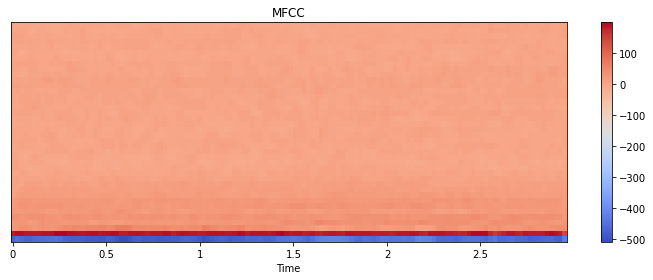

In [ ]:
# MFCC of NoQueenBee
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()


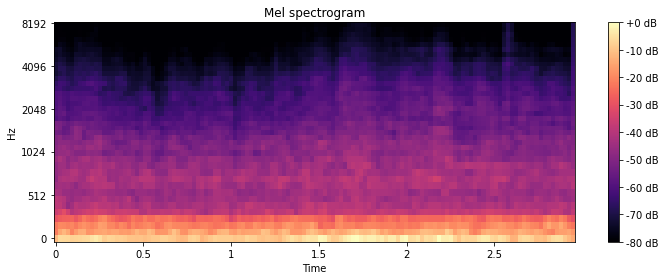

In [ ]:
# Melspectrogram of a NoQueenBee
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(
    melspectrogram, ref=np.max), y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()


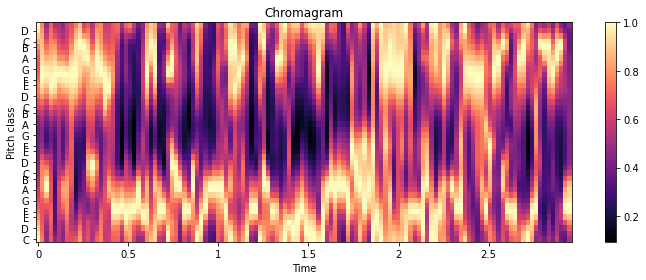

In [ ]:
# Chromagram of NoQueenBee
plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma_stft, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Chromagram')
plt.tight_layout()


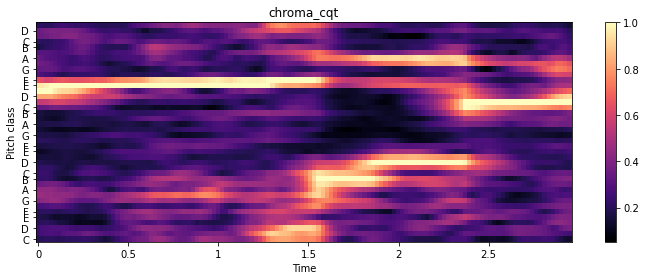

In [ ]:
# Chroma cqt of a NoQueenBee
plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma_cq, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('chroma_cqt')
plt.tight_layout()


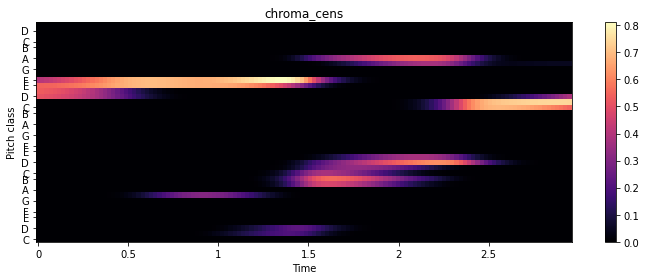

In [ ]:
# Chroma cens of a NoQueenBee
plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma_cens, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('chroma_cens')
plt.tight_layout()


### Data Preprocessing

In [ ]:
# feature set
y, sr = librosa.load(r"Data Bee\Splitted Recordings 2.96 0.75\NoQueenBee bee 1 CF001 - Missing Queen - Day - 0 - 2.96 .wav",sr=SAMPLE_RATE)
mfccs = np.mean(librosa.feature.mfcc(y = y, sr = sr, n_mfcc=40).T, axis=0)
melspectrogram = np.mean(librosa.feature.melspectrogram(
    y=y, sr=sr, n_mels=40, fmax=8000).T, axis=0)
chroma_stft = np.mean(librosa.feature.chroma_stft(
    y=y, sr=sr, n_chroma=40).T, axis=0)
chroma_cq = np.mean(librosa.feature.chroma_cqt(
    y=y, sr=sr, n_chroma=40, bins_per_octave=40).T, axis=0)
chroma_cens = np.mean(librosa.feature.chroma_cens(
    y=y, sr=sr, n_chroma=40, bins_per_octave=40).T, axis=0)
melspectrogram.shape, chroma_stft.shape, chroma_cq.shape, chroma_cens.shape, mfccs.shape

((40,), (40,), (40,), (40,), (40,))

In [ ]:
#stacking and reshaping
features = np.reshape(np.vstack(
    (mfccs, melspectrogram, chroma_stft, chroma_cq, chroma_cens)), (40, 5))
features.shape

(40, 5)

In [ ]:
x_preprocessed = []
y_preprocessed = []

for i in tqdm(range(len(paths))):
    filename = paths[i]
    label = os.path.split(filename)[-1].split()[0]
    y, sr = librosa.load(filename,sr=SAMPLE_RATE)
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    melspectrogram = np.mean(librosa.feature.melspectrogram(
        y=y, sr=sr, n_mels=40, fmax=8000).T, axis=0)
    chroma_stft = np.mean(librosa.feature.chroma_stft(
        y=y, sr=sr, n_chroma=40).T, axis=0)
    chroma_cq = np.mean(librosa.feature.chroma_cqt(
        y=y, sr=sr, n_chroma=40, bins_per_octave=40).T, axis=0)
    chroma_cens = np.mean(librosa.feature.chroma_cens(
        y=y, sr=sr, n_chroma=40, bins_per_octave=40).T, axis=0)
    features = np.reshape(np.vstack(
        (mfccs, melspectrogram, chroma_stft, chroma_cq, chroma_cens)), (40, 5))

    x_preprocessed.append(features)
    y_preprocessed.append(label)


  0%|          | 0/7362 [00:00<?, ?it/s]C:\Users\5to4e\AppData\Roaming\Python\Python310\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=1020
  return f(*args, **kwargs)
  0%|          | 3/7362 [00:02<1:28:12,  1.39it/s]C:\Users\5to4e\AppData\Roaming\Python\Python310\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=820
  return f(*args, **kwargs)
  0%|          | 4/7362 [00:02<1:29:38,  1.37it/s]C:\Users\5to4e\AppData\Roaming\Python\Python310\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=796
  return f(*args, **kwargs)
  1%|          | 46/7362 [00:33<1:27:13,  1.40it/s]C:\Users\5to4e\AppData\Roaming\Python\Python310\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=807
  return f(*args, **kwargs)
  1%|          | 48/7362 [00:34<1:27:21,  1.40it/s]C

In [ ]:
x_preprocessed = np.array(x_preprocessed)
y_preprocessed = np.array(y_preprocessed)
x_preprocessed.shape,y_preprocessed.shape

((7362, 40, 5), (7362,))

In [ ]:
# reshaping into 2d to save in csv format
x_preprocessed_2d = np.reshape(
    x_preprocessed, (x_preprocessed.shape[0], x_preprocessed.shape[1]*x_preprocessed.shape[2]))
x_preprocessed_2d.shape

(7362, 200)

### Store Processed Data

In [ ]:
# saving the data numpy arrays
np.savetxt("Data Bee Save/x_preprocessed.csv", x_preprocessed_2d, delimiter=",")
np.savetxt("Data Bee Save/y_preprocessed.csv", y_preprocessed, delimiter=",", fmt='%s')